<a href="https://colab.research.google.com/github/Krishnaugale353/Upgrad-Capstone/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


jhb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim

from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [4]:
data=pd.read_csv('/content/drive/MyDrive/Final Capstone Project/Intensity.csv')

In [5]:
# Check the shape of the combined dataset
print("Dataset dimensions:", data.shape)


Dataset dimensions: (2039, 2)


In [6]:
# Display the first 5 rows of the combined dataset
data.head()


,content,intensity
0,Wants to know how the hell I can remember word...,happiness
1,Love is a long sweet dream & marriage is an al...,happiness
2,The world could be amazing when you are slight...,happiness
3,My secret talent is getting tired without doin...,happiness
4,"Khatarnaak Whatsapp Status Ever… Can\’t talk, ...",happiness


In [7]:
# Check for any missing values in the dataset
data.isnull().sum()


,0
content,0
intensity,0


In [8]:
# Count the number of each label in the 'intensity' column
data['intensity'].value_counts()


,count
intensity,
happiness,708
angriness,696
sadness,635


In [9]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 9.4 MB/s eta 0:00:00


In [10]:
import emoji

# Define a function to convert emojis to text descriptions
def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Converts emojis to text descriptions

# Apply the function to your 'cleaned_content' column
data['content'] = data['content'].apply(convert_emojis_to_text)

# Example: 😀 gets converted to ':grinning_face:'
print(data['content'].head())


0    Wants to know how the hell I can remember word...
1    Love is a long sweet dream & marriage is an al...
2    The world could be amazing when you are slight...
3    My secret talent is getting tired without doin...
4    Khatarnaak Whatsapp Status Ever… Can\’t talk, ...
Name: content, dtype: object


In [11]:
duplicate_count = data.duplicated().sum()
print("Number of duplicate entries:", duplicate_count)

Number of duplicate entries: 447


In [12]:
# Remove duplicate entries
data = data.drop_duplicates()

# Check the new dimensions of the dataset
print("New dataset dimensions:", data.shape)


New dataset dimensions: (1592, 2)


In [13]:
# Load NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
data.columns

Index(['content', 'intensity'], dtype='object')

In [15]:
# Convert all text to lowercase
data['content'] = data['content'].str.lower()

# Remove special characters, numbers, and punctuations
data['content'] = data['content'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Display a sample of the cleaned text
print(data['content'].head())

0    wants to know how the hell i can remember word...
1    love is a long sweet dream  marriage is an ala...
2    the world could be amazing when you are slight...
3    my secret talent is getting tired without doin...
4    khatarnaak whatsapp status ever cant talk wife...
Name: content, dtype: object


In [16]:
# Download stopwords if you haven't already
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from the 'content' column
data['content'] = data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Display a sample of the text after stopword removal
print(data['content'].head())

0    wants know hell remember words songs years ago...
1           love long sweet dream marriage alarm clock
2                 world could amazing slightly strange
3    secret talent getting tired without anything g...
4    khatarnaak whatsapp status ever cant talk wife...
Name: content, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to each word in the content
data['content'] = data['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Display a sample of the lemmatized text
print(data['content'].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


0    want know hell remember word song year ago can...
1           love long sweet dream marriage alarm clock
2                 world could amazing slightly strange
3    secret talent getting tired without anything g...
4    khatarnaak whatsapp status ever cant talk wife...
Name: content, dtype: object


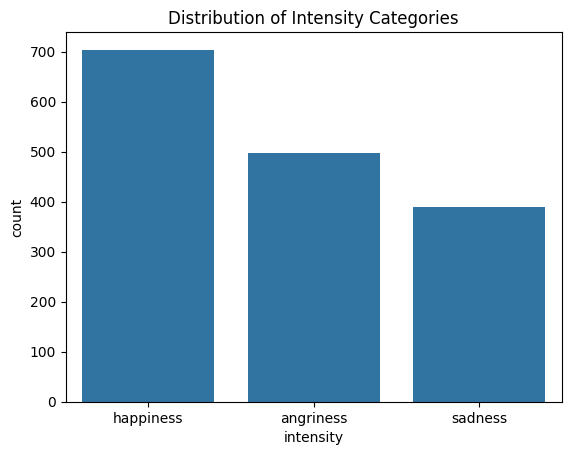

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of intensity labels
sns.countplot(x='intensity', data=data)
plt.title("Distribution of Intensity Categories")
plt.show()


In [19]:
data['intensity'].value_counts()


,count
intensity,
happiness,704
angriness,498
sadness,390


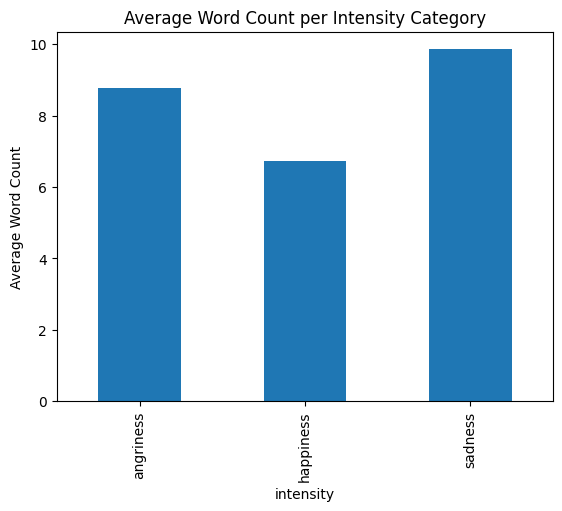

In [20]:
data['word_count'] = data['content'].apply(lambda x: len(x.split()))

# Plot the average word count per intensity
data.groupby('intensity')['word_count'].mean().plot(kind='bar')
plt.title("Average Word Count per Intensity Category")
plt.ylabel("Average Word Count")
plt.show()


In [21]:
# Original dataset remains unchanged
original_data = data.copy()


In [22]:
def get_avg_word2vec(sentence, model, vector_size):
    """
    Calculate the average Word2Vec embedding for a sentence.

    Parameters:
    - sentence: list of words (tokens) from a sentence.
    - model: trained Word2Vec model containing word embeddings.
    - vector_size: the size of each word vector in the model.

    Returns:
    - A vector representing the average of all word embeddings in the sentence.
      If no words from the sentence are found in the model, returns a zero vector of size 'vector_size'.
    """
    words = [word for word in sentence if word in model.wv]  # Check if words are in the model's vocabulary
    if len(words) > 0:
        # Average all word vectors for words in the sentence
        return np.mean(model.wv[words], axis=0)
    else:
        # Return a zero vector if none of the words are in the model's vocabulary
        return np.zeros(vector_size)


In [23]:
# Create a copy for handling class imbalance after embeddings
after_embedding_data = data.copy()

# Prepare text data for Word2Vec
text_data_after = [content.split() for content in after_embedding_data['content']]

# Train a Word2Vec model on your text data
w2v_model_after = Word2Vec(sentences=text_data_after, vector_size=100, window=5, min_count=1, sg=1)

# Generate Word2Vec embeddings for the 'after_embedding_data'
after_embedding_data['content_vector'] = after_embedding_data['content'].apply(lambda x: get_avg_word2vec(x.split(), w2v_model_after, 100))


In [24]:
# Prepare feature matrix and target vector for SMOTE
X_after = np.array(after_embedding_data['content_vector'].tolist())  # Now we have fixed-size vectors
y_after = after_embedding_data['intensity'].values

# Apply SMOTE to balance classes

smote_after = SMOTE(random_state=42)
X_resampled_after, y_resampled_after = smote_after.fit_resample(X_after, y_after)

# Update the balanced data into 'after_embedding_data'
after_embedding_data = pd.DataFrame({'content_vector': X_resampled_after.tolist(), 'intensity': y_resampled_after})


In [26]:
after_embedding_data['intensity'].value_counts()


,count
intensity,
happiness,704
angriness,704
sadness,704


In [27]:
after_embedding_data.head()

,content_vector,intensity
0,"[-0.09821334481239319, 0.09453018009662628, 0....",happiness
1,"[-0.0649186447262764, 0.06012158840894699, 0.0...",happiness
2,"[-0.0779467448592186, 0.07268504798412323, 0.0...",happiness
3,"[-0.0965454950928688, 0.09375711530447006, 0.0...",happiness
4,"[-0.12648656964302063, 0.12586770951747894, 0....",happiness


In [28]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'intensity' column
after_embedding_data['intensity'] = label_encoder.fit_transform(after_embedding_data['intensity'])

# Display the encoded labels
print("Encoded Labels Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print(after_embedding_data.head())


Encoded Labels Mapping: {'angriness': 0, 'happiness': 1, 'sadness': 2}
                                      content_vector  intensity
0  [-0.09821334481239319, 0.09453018009662628, 0....          1
1  [-0.0649186447262764, 0.06012158840894699, 0.0...          1
2  [-0.0779467448592186, 0.07268504798412323, 0.0...          1
3  [-0.0965454950928688, 0.09375711530447006, 0.0...          1
4  [-0.12648656964302063, 0.12586770951747894, 0....          1


In [29]:
from sklearn.model_selection import train_test_split

# Prepare features (X) and labels (y)
X = np.array(after_embedding_data['content_vector'].tolist())  # Convert content vectors to NumPy array
y = after_embedding_data['intensity'].values  # Encoded labels

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (1689, 100)
Testing set size: (423, 100)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", accuracy)

# Print a classification report for detailed metrics
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Random Forest Classifier Accuracy: 0.723404255319149
Classification Report:
               precision    recall  f1-score   support

   angriness       0.75      0.74      0.75       133
   happiness       0.70      0.65      0.67       150
     sadness       0.72      0.79      0.75       140

    accuracy                           0.72       423
   macro avg       0.72      0.73      0.72       423
weighted avg       0.72      0.72      0.72       423



In [31]:
before_embedding_data = data.copy()


In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Prepare the text and labels from the unbalanced data
X_text = before_embedding_data['content']  # The text data
y_before = before_embedding_data['intensity']  # The target labels

# Convert text data into a vectorized form using CountVectorizer (needed for SMOTE)
vectorizer = CountVectorizer()  # Using a basic vectorizer to apply SMOTE (embeddings come later)
X_vectorized = vectorizer.fit_transform(X_text)


In [33]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with a random state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE on the vectorized features and labels
X_smote, y_smote = smote.fit_resample(X_vectorized, y_before)

# Verify the class distribution after SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_smote).value_counts())


Class distribution after SMOTE:
 intensity
happiness    704
angriness    704
sadness      704
Name: count, dtype: int64


In [34]:
# Get the feature matrix back as a list of words (since we only need the counts for SMOTE)
resampled_text = vectorizer.inverse_transform(X_smote)

# Combine the text and resampled labels into a DataFrame
balanced_data_before_embeddings = pd.DataFrame({
    'content': [' '.join(words) for words in resampled_text],  # Combine words back into text
    'intensity': y_smote
})

# Check the new dataset dimensions and the first few entries
print("Balanced dataset dimensions:", balanced_data_before_embeddings.shape)
balanced_data_before_embeddings.head()


Balanced dataset dimensions: (2112, 2)


,content,intensity
0,want know hell remember word song year ago can...,happiness
1,love long sweet dream marriage alarm clock,happiness
2,world could amazing slightly strange,happiness
3,secret talent getting tired without anything g...,happiness
4,cant khatarnaak whatsapp status ever talk wife...,happiness


In [35]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply the label encoder to the 'intensity' column
balanced_data_before_embeddings['intensity'] = label_encoder.fit_transform(balanced_data_before_embeddings['intensity'])

# Display the mapping of encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Check the updated dataset
balanced_data_before_embeddings.head()


Label Mapping: {'angriness': 0, 'happiness': 1, 'sadness': 2}


,content,intensity
0,want know hell remember word song year ago can...,1
1,love long sweet dream marriage alarm clock,1
2,world could amazing slightly strange,1
3,secret talent getting tired without anything g...,1
4,cant khatarnaak whatsapp status ever talk wife...,1


In [37]:
!nvidia-smi

Thu Oct 24 12:56:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [38]:
!pip install transformers
!pip install torch  # If using PyTorch


In [39]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        return_tensors='pt',  # Return as PyTorch tensors
        max_length=128  # You can adjust this based on your data
    )

# Encode the content
encoded_data = encode_texts(balanced_data_before_embeddings['content'])

# Display the shape of encoded input IDs and attention masks
print("Encoded Input IDs Shape:", encoded_data['input_ids'].shape)
print("Encoded Attention Masks Shape:", encoded_data['attention_mask'].shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encoded Input IDs Shape: torch.Size([2112, 128])
Encoded Attention Masks Shape: torch.Size([2112, 128])


In [40]:
from sklearn.model_selection import train_test_split
import torch

# Prepare features and labels
X = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
y = balanced_data_before_embeddings['intensity'].values

# Split the data into training and validation sets
X_train, X_val, attention_masks_train, attention_masks_val, y_train, y_val = train_test_split(
    X, attention_masks, y, test_size=0.2, random_state=42
)

# Convert the data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(X_train, attention_masks_train, torch.tensor(y_train))
val_dataset = torch.utils.data.TensorDataset(X_val, attention_masks_val, torch.tensor(y_val))

# Check the sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 1689
Validation set size: 423


In [43]:
import torch
from transformers import BertForSequenceClassification

# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [44]:
from transformers import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set the training parameters
epochs = 3
batch_size = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()  # Clear gradients
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Average Training Loss for Epoch {epoch + 1}: {avg_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 106/106 [00:33<00:00,  3.17it/s]


Average Training Loss for Epoch 1: 0.9398


Training Epoch 2: 100%|██████████| 106/106 [00:33<00:00,  3.12it/s]


Average Training Loss for Epoch 2: 0.6133


Training Epoch 3: 100%|██████████| 106/106 [00:36<00:00,  2.93it/s]

Average Training Loss for Epoch 3: 0.3949


In [45]:
from sklearn.metrics import classification_report, accuracy_score

# Set the model to evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
predictions = []
true_labels = []

# Disable gradient calculation
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted labels
        preds = torch.argmax(logits, dim=1)

        # Store predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

# Generate a classification report
report = classification_report(true_labels, predictions, target_names=['happiness', 'angriness', 'sadness'])
print(report)



Validating: 100%|██████████| 27/27 [00:03<00:00,  8.31it/s]


Validation Accuracy: 0.7400
              precision    recall  f1-score   support

   happiness       0.68      0.78      0.72       133
   angriness       0.85      0.66      0.74       150
     sadness       0.72      0.79      0.75       140

    accuracy                           0.74       423
   macro avg       0.75      0.74      0.74       423
weighted avg       0.75      0.74      0.74       423



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7c2943316560>